# Import libraries

In [ ]:
! pip install torchaudio-augmentations

In [11]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)
# Enable xla for speed up
tf.config.optimizer.set_jit(True)

# Import required tensorflow modules
# import tensorflow_io as tfio
# import tensorflow_addons as tfa
# import tensorflow_probability as tfp
# import tensorflow.keras.backend as K

# Import KaggleDatasets for accessing Kaggle datasets
from kaggle_datasets import KaggleDatasets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from torchvision import transforms
from torch.cuda.amp import autocast as autocast, GradScaler
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers.optimization import get_cosine_schedule_with_warmup
import torch.nn.functional as F

2023-04-07 04:28:37.985894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 04:28:38.111901: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 04:28:38.820531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nv

# Config

In [2]:
class CFG:
    # Debugging
    debug = False
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    _wandb_kernel = 'awsaf49'
    
    # Experiment name and comment
    exp_name = 'baseline-v2'
    comment = 'EfficientNetB0|FSR|t=10s|128x384|up_thr=50|cv_filter'
    
    # Notebook link
    notebook_link = 'https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit'
    
    # Verbosity level
    verbose = 0
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB0'
    fsr = True # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Data augmentation parameters
    augment=True
    
    # Spec augment
    spec_augment_prob = 0.80
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 0.5
    
    mask_prob = 0.65
    freq_mask = 20
    time_mask = 30


    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'

# Reproducibility

In [3]:
from transformers import set_seed
set_seed(CFG.seed)

# Device

In [ ]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu
# strategy, CFG.device, tpu = get_device()
# CFG.replicas = strategy.num_replicas_in_sync

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Original Dataloader

In [ ]:
BASE_PATH = '/kaggle/input/birdclef-2023'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])
else:
    GCS_PATH = BASE_PATH

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = GCS_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

## Data utils

In [ ]:
import cv2

def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def show_image(filename):
    img = cv2.imread(f'/kaggle/input/birdclef23-image-dataset/{filename}.jpg')
    img = img[...,::-1] # bgr => rgb
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('OFF')
    plt.show()
    return img

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    # print("# Image:")
    # show_image(row.common_name)
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## show data

In [ ]:
stat = df.primary_label.value_counts().index.tolist()
class_names = stat[:3] + stat[-3:] # popular + not popular

In [ ]:
class_name = class_names[0]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

## Data split

In [ ]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

In [ ]:
df.groupby(['fold','primary_label']).size()

## Filter Data and Upsample Data

In [ ]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

In [ ]:
# Filter data
f_df = filter_data(df, thr=5)
f_df.cv.value_counts().plot.bar(legend=True)
plt.yscale("log")
plt.title("Cross Validation samples")
plt.show()

In [ ]:
# Upsample data
up_df = upsample_data(df, thr=50)
print(f'Before Upsample Size: {len(df)}')
print(f'After Upsample Size: {len(up_df)}')

# Show effect of upsample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
up_df.primary_label.value_counts()[:].plot.bar(ax=ax, color='green', label='w/ upsample')
df.primary_label.value_counts()[:].plot.bar(ax=ax, color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=50, color='k', linestyle='--', label='threshold')
plt.legend()
plt.title("Effect of Upsample")
plt.show()

## Audio Augmentation

In [20]:
from torchaudio.utils import download_asset
import torchaudio
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
audio_data, sr = torchaudio.load(SAMPLE_SPEECH)
print(sr)
print(audio_data.shape)

8000
torch.Size([1, 27200])


In [21]:
from torchaudio_augmentations import *

def audio_augmentation(audio_data, sr, 
                       num_augmented_sampels=4,
                       num_samples=sr*2,
                       polarity_p=0.8, 
                       min_snr=0.001, 
                       max_snr=0.005, 
                       noise_p=0.3, 
                       gain_p=0.2, 
                       delay_p=0.5, 
                       shift_p=0.4, 
                       reverb_p=0.3):
    if num_samples>audio_data.shape[1]:
        num_samples = audio_data.shape[1]
    
    transforms = [
                RandomResizedCrop(n_samples=num_samples),
                RandomApply([PolarityInversion()], p=polarity_p),
                RandomApply([Noise(min_snr=min_snr, max_snr=max_snr)], p=noise_p),
                RandomApply([Gain()], p=gain_p),
                HighLowPass(sample_rate=sr), # this augmentation will always be applied in this aumgentation chain!
                RandomApply([Delay(sample_rate=sr)], p=delay_p),
                RandomApply([PitchShift(
                    n_samples=num_samples,
                    sample_rate=sr
                )], p=shift_p),
                RandomApply([Reverb(sample_rate=sr)], p=reverb_p)]   
    transforms = ComposeMany(transforms=transforms, num_augmented_samples=num_augmented_sampels)
    audio_aug = transforms(audio_data)
    return audio_aug

# num_samples = sr * 2
# transforms = [
#     RandomResizedCrop(n_samples=num_samples),
#     RandomApply([PolarityInversion()], p=0.8),
#     RandomApply([Noise(min_snr=0.001, max_snr=0.005)], p=0.3),
#     RandomApply([Gain()], p=0.2),
#     HighLowPass(sample_rate=sr), # this augmentation will always be applied in this aumgentation chain!
#     RandomApply([Delay(sample_rate=sr)], p=0.5),
#     RandomApply([PitchShift(
#         n_samples=num_samples,
#         sample_rate=sr
#     )], p=0.4),
#     RandomApply([Reverb(sample_rate=sr)], p=0.3)
# ]
# audio_transforms = ComposeMany(transforms=transforms, num_augmented_samples=4)
# audio_aug = audio_transforms(audio_data)
# print(audio_aug.shape)
audio_aug = audio_augmentation(audio_data, sr, num_augmented_sampels=4, num_samples=sr*2)

# Audio:


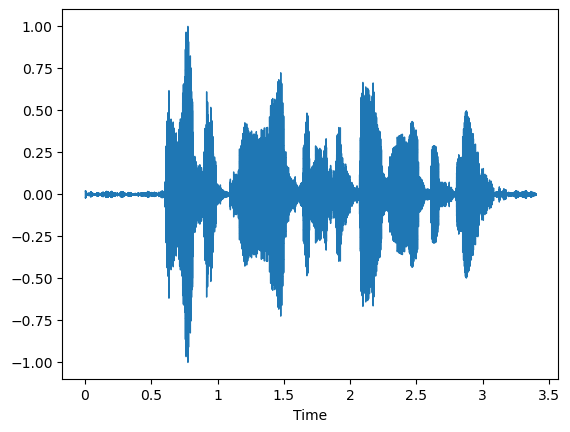

In [22]:
print("# Audio:")
display(ipd.Audio(audio_data, rate=sr))
lid.waveshow(audio_data.numpy(), sr=sr)


# Augmetation Audio 1:


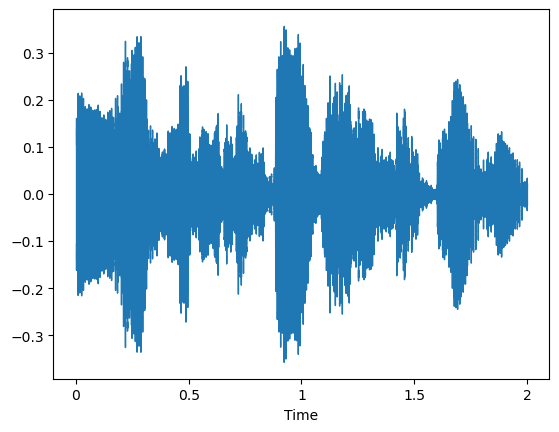

In [23]:
print("# Augmetation Audio 1:")
display(ipd.Audio(audio_aug[0], rate=sr))
lid.waveshow(audio_aug[0].numpy(), sr=sr)